In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn.functional as F
from dotenv import load_dotenv
from scipy.stats import wasserstein_distance


from data.load_tokens import DATA_FILES, combinations
from datasets import load_dataset

data = {}
divs = {}
tok_z = {}
tok_z_p = {}

load_dotenv()

DATA_ROOT = os.getenv("DATA_ROOT")
DATA_FOLDER = os.getenv("DATA_FOLDER")
base = Path(DATA_ROOT) / DATA_FOLDER

/home/phys2526/AION1_experiments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1025
3815


In [2]:
import scienceplots

plt.style.use("science")

In [3]:
from data.load_data import load_data
table = load_data()

In [4]:
for name in combinations.keys():
    data[name] = load_dataset("parquet", data_files=DATA_FILES, split=name)

#combinations.pop("true_z")

true_z = torch.tensor(data["true_z"]["tok_z"])
true_z_p = F.softmax(true_z, dim=-1)

for name in combinations.keys():
    tok_z[name] = torch.tensor(data[name]["tok_z"])
    tok_z_p[name] = F.softmax(tok_z[name], dim=-1)

    '''
    KL_div = torch.sum(
        true_z_p * (torch.log(true_z_p) - torch.log(tok_z_p)),
        dim=-1
    )
    '''

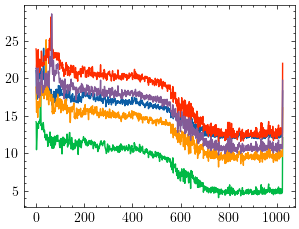

In [5]:
for i in range(5):
    plt.plot(
        tok_z["true_z"][i, :].detach().cpu().numpy()
    )

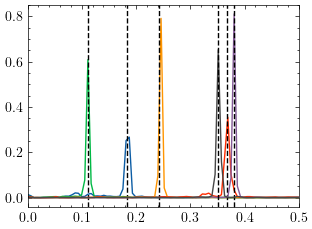

In [6]:
for i in range(6):
    z = tok_z_p["true_z"][i, :].detach().cpu().numpy()
    plt.plot(
        np.linspace(0, 6, len(z)),
        z
    )

    plt.axvline(
        table[i]["Z_HP"],
        ls="--",
        c="black"
    )
    plt.xlim(0, 0.5)

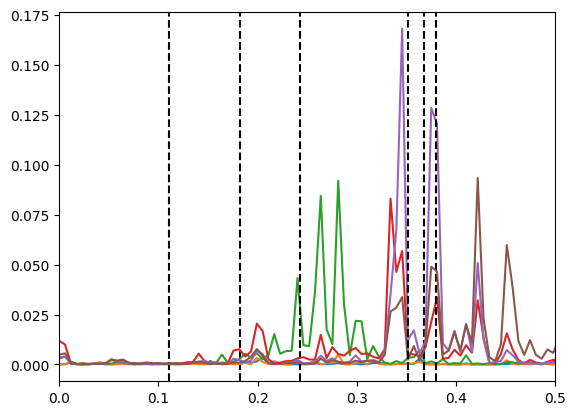

In [6]:
for i in range(6):
    z = tok_z_p["photometry"][i, :].detach().cpu().numpy()
    plt.plot(
        np.linspace(0, 6, len(z)),
        z
    )

    plt.axvline(
        table[i]["Z_HP"],
        ls="--",
        c="black"
    )
    plt.xlim(0, 0.5)

In [9]:
def w1_distance_batched(u, v):
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if u.ndim != 2:
        raise ValueError("Expected (batch, n) tensors.")

    u = u.to(torch.float64)
    v = v.to(torch.float64)

    u_sorted, _ = torch.sort(u, dim=-1)
    v_sorted, _ = torch.sort(v, dim=-1)

    all_values = torch.cat((u_sorted, v_sorted), dim=-1)
    all_values, _ = torch.sort(all_values, dim=-1)

    deltas = torch.diff(all_values, dim=-1)      # (batch, 2n-1)
    points = all_values[..., :-1]               # (batch, 2n-1)

    u_cdf_indices = torch.searchsorted(u_sorted, points, right=True)
    v_cdf_indices = torch.searchsorted(v_sorted, points, right=True)

    n = u.shape[-1]
    u_cdf = u_cdf_indices / n
    v_cdf = v_cdf_indices / n

    return torch.sum(torch.abs(u_cdf - v_cdf) * deltas, dim=-1)

In [56]:
w1s = {}

for idx, name in enumerate(list(tok_z_p.keys())):
    u = torch.zeros_like(tok_z_p[name].detach().cpu())
    if idx == 0:
        B = u.size(0)
        batch_idx = torch.arange(B)
        quant_z = torch.round((torch.tensor(table["Z_HP"].tolist())/ 6.0)*1025.0).to(torch.int32) # 1024 or 1025?
    
    u[batch_idx, quant_z] = torch.tensor(1.0)

    w1s[name] = w1_distance_batched(
        u, tok_z_p[name]
    )

In [57]:
# plot the distributions of w1
labels = ['Z', 'Photometry', 'Imaging', 'Spectroscopy', 'Image + Photometry', 'Image + Spectrum', 'Image + Spectrum + Photometry', 'Image + Spectrum + Photometry + Z']
df = pd.DataFrame(
    data=w1s,
)
df.columns = labels

[None, None, None, None, None, None, None, None]

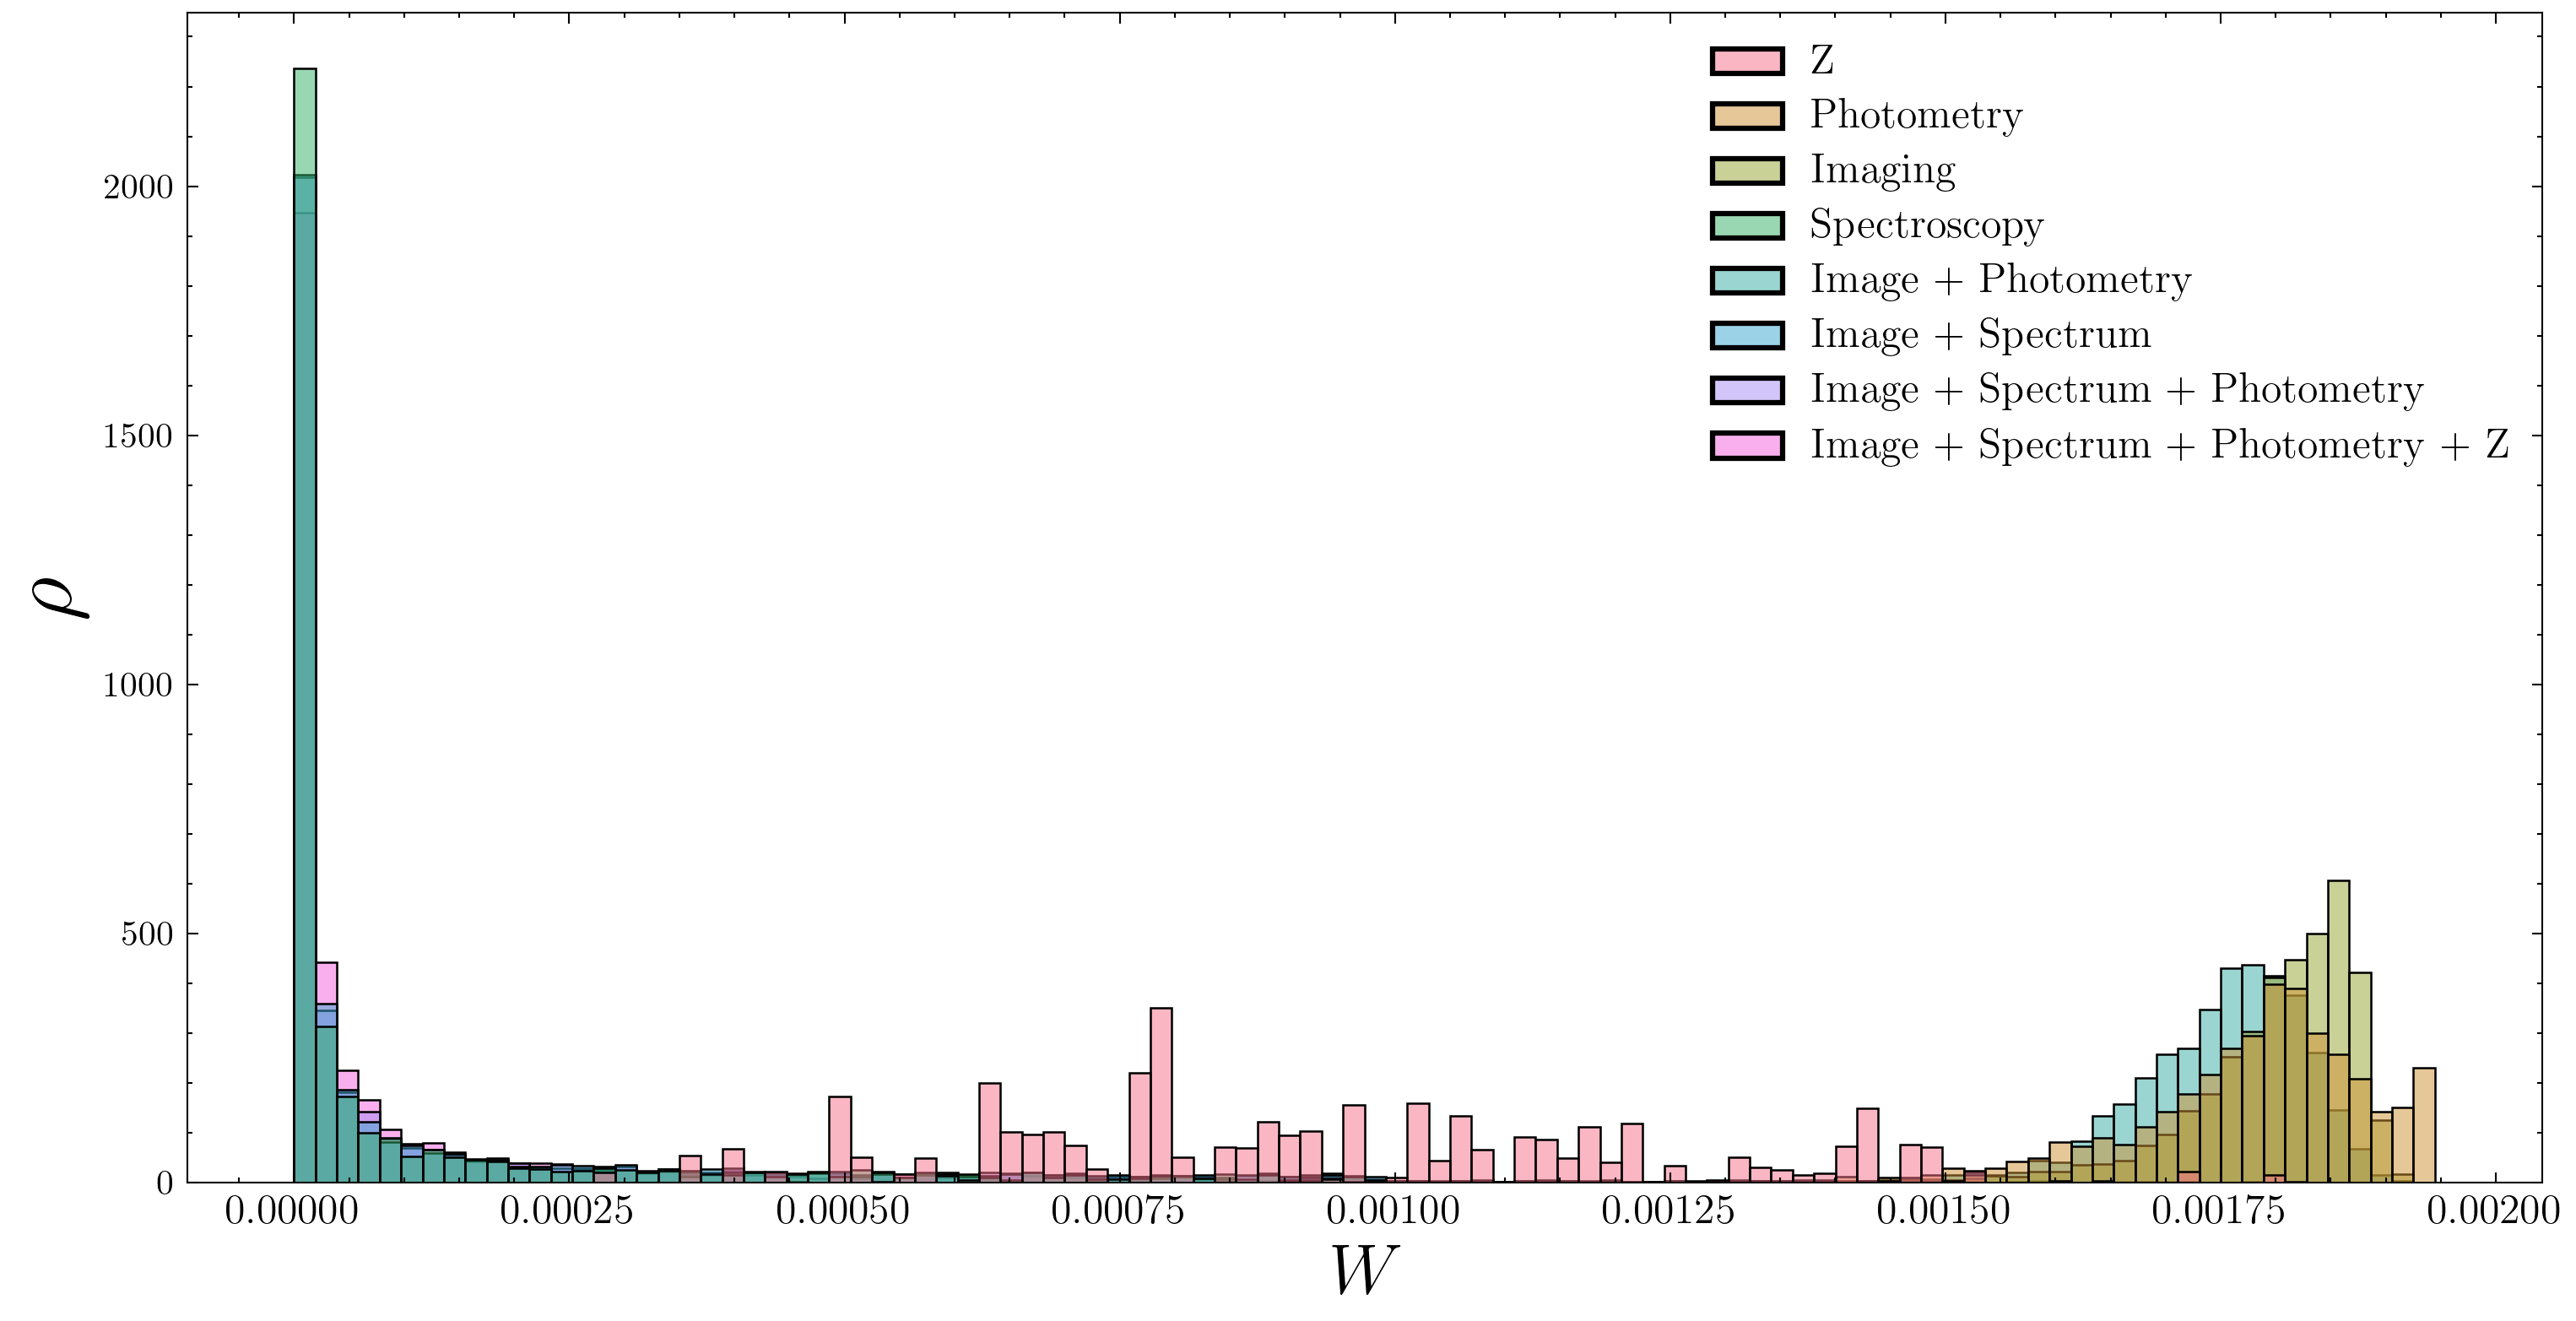

In [58]:
# Images of examples showing the quantizied redshifts
# Demo the Wasserstein distances on the plots.

plt.figure(
    figsize=(12,6),
    dpi=300
)
ax = sns.histplot(
    df,
    lw=1.5,
    bins=100
)

#ax = sns.histplot(data=df_log, stat="density", element="step", fill=True)

plt.ylabel(r"$\rho$", fontsize=25)
plt.xlabel(
    r"$W$",
    fontsize=20
)
plt.xticks(
    fontsize=12
)
#plt.xscale("log")
plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text

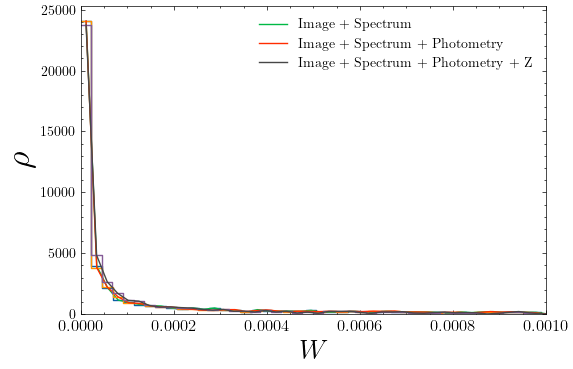

In [14]:
fig, ax = plt.subplots(
    figsize=(6,4)
)

cols = ['Image + Spectrum', 'Image + Spectrum + Photometry', 'Image + Spectrum + Photometry + Z']

for col in cols:
    sns.histplot(df[col], bins=75, lw=1.0, ax=ax, stat="density", element="step", fill=False)

    hist, edges = np.histogram(df[col], bins=75, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    ax.plot(centers, hist, label=f"{col}")


plt.ylabel(r"$\rho$", fontsize=25)
plt.xlabel(
    r"$W$",
    fontsize=20
)
plt.xticks(
    fontsize=12
)

plt.xlim(0, 1e-3)

ax.legend()

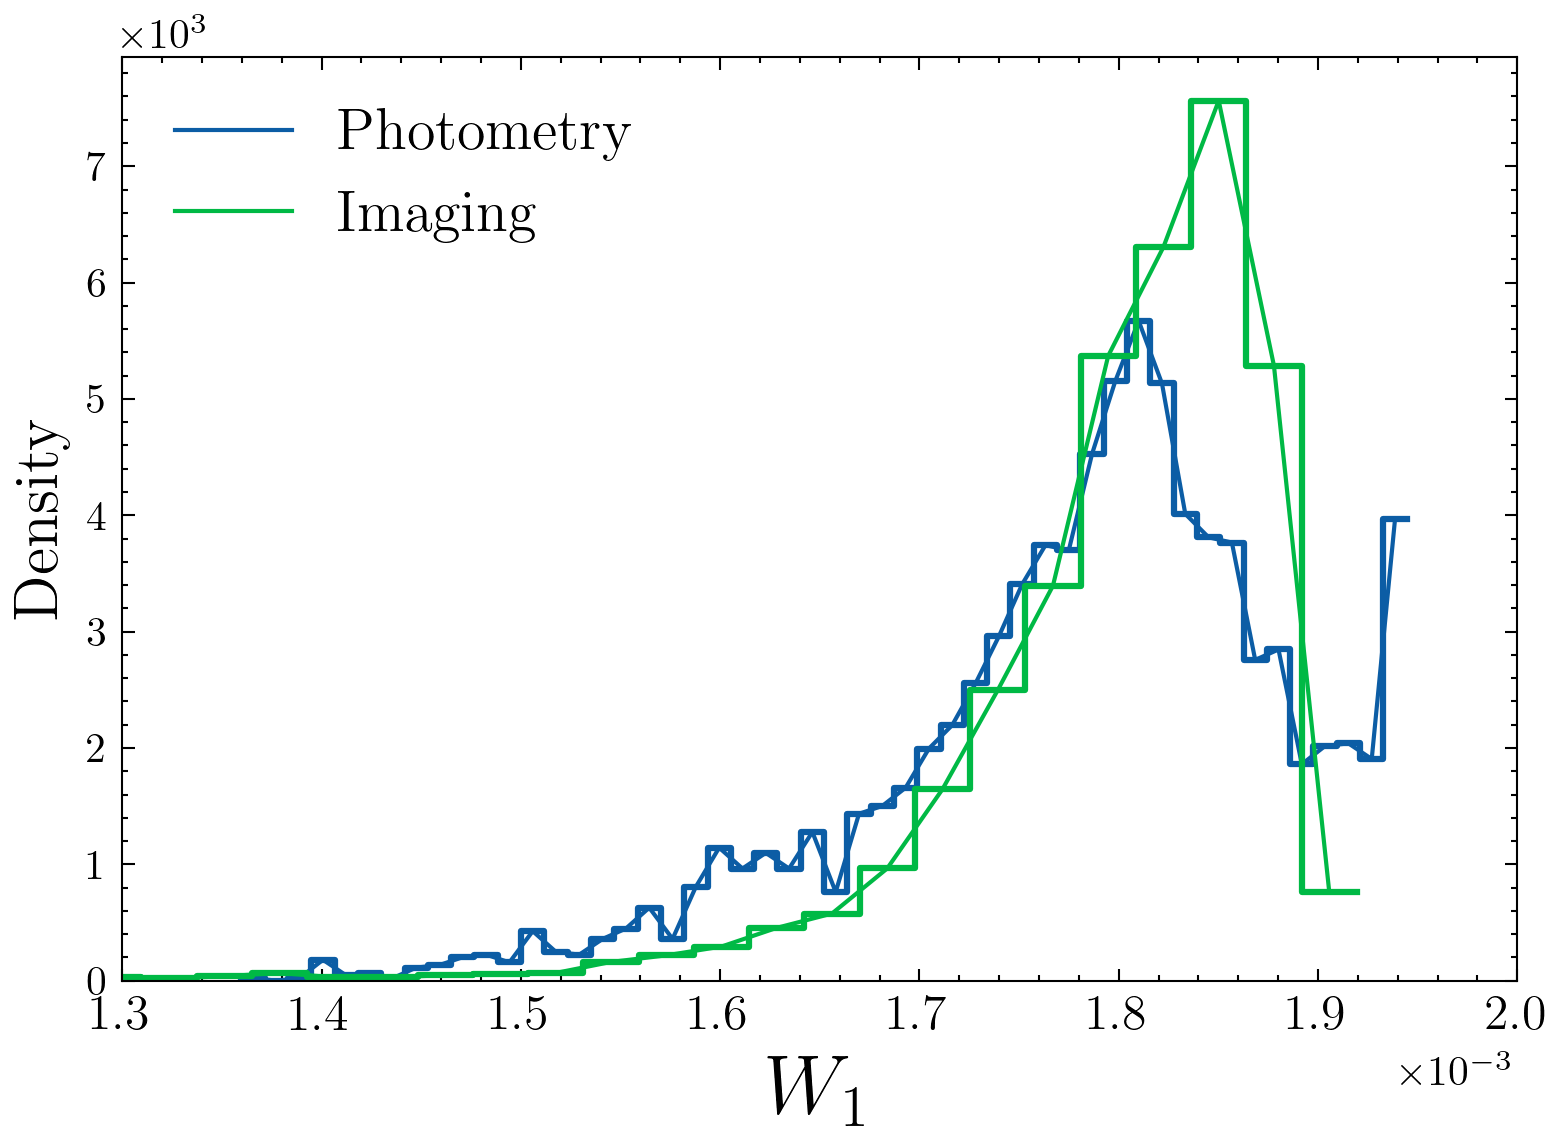

In [60]:
fig, ax = plt.subplots(
    figsize=(6,4),
    dpi=300
)

cols = ['Photometry', 'Imaging'] #, 'Image + Photometry']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for col, color in zip(cols, colors):
    sns.histplot(df[col], bins=50, lw=1.5, ax=ax, stat="density", element="step", fill=False, color=color)
    #sns.kdeplot(df[col], lw=1.5)

    hist, edges = np.histogram(df[col], bins=50, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    ax.plot(centers, hist, label=f"{col}", color=color)

plt.ylabel(r"Density", fontsize=15)
plt.xlabel(
    r"$W_{1}$",
    fontsize=20
)
plt.xticks(
    fontsize=12
)
plt.ticklabel_format(axis='both', style='sci', scilimits=(4,-4))

plt.xlim(1.3e-3, 2e-3)
ax.legend(fontsize=14)

In [50]:
w1s_pi = {}

for idx, name in enumerate(['photometry', 'imaging']):
    '''u = torch.zeros_like(tok_z_p[name].detach().cpu())
    if idx == 0:
        B = u.size(0)
        batch_idx = torch.arange(B)
        quant_z = torch.round((torch.tensor(table["Z_HP"].tolist())/ 6.0)*1024.0).to(torch.int32)
    
    u[batch_idx, quant_z] = torch.tensor(1.0)'''

    u = tok_z_p[name].detach().cpu()
    w1s_pi[name] = w1_distance_batched(
        u, tok_z_p["image_photometry"]
    )

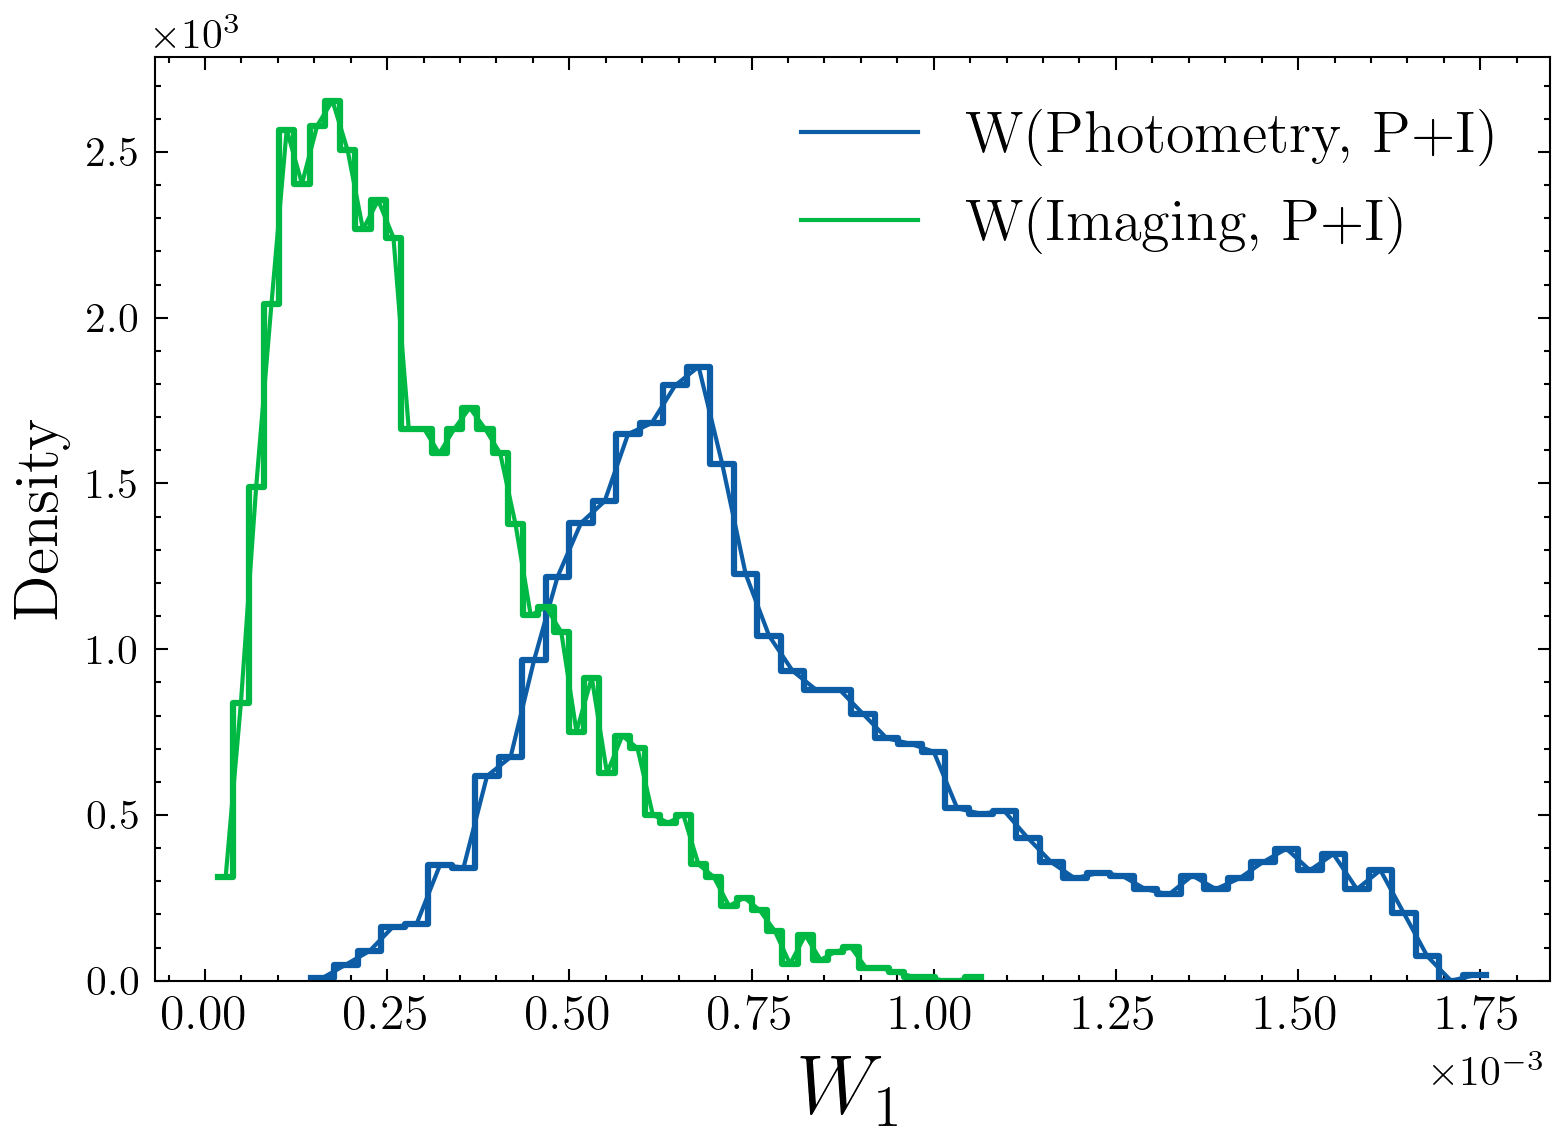

In [64]:
# plot the distributions of w1
labels = ['Photometry', 'Imaging']
df_pi = pd.DataFrame(
    data=w1s_pi,
)
df_pi.columns = labels

fig, ax = plt.subplots(
    figsize=(6,4),
    dpi=300
)

cols = labels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for col, color in zip(cols, colors):
    sns.histplot(df_pi[col], bins=50, lw=1.5, ax=ax, stat="density", element="step", fill=False, color=color)
    #sns.kdeplot(df[col], lw=1.5)

    hist, edges = np.histogram(df_pi[col], bins=50, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    ax.plot(centers, hist, label=f"W({col}, P+I)", color=color)


plt.ylabel(r"Density", fontsize=15)
plt.xlabel(
    r"$W_{1}$",
    fontsize=20
)
plt.xticks(
    fontsize=12
)

plt.ticklabel_format(axis='both', style='sci', scilimits=(4,-4))


ax.legend(fontsize=14)

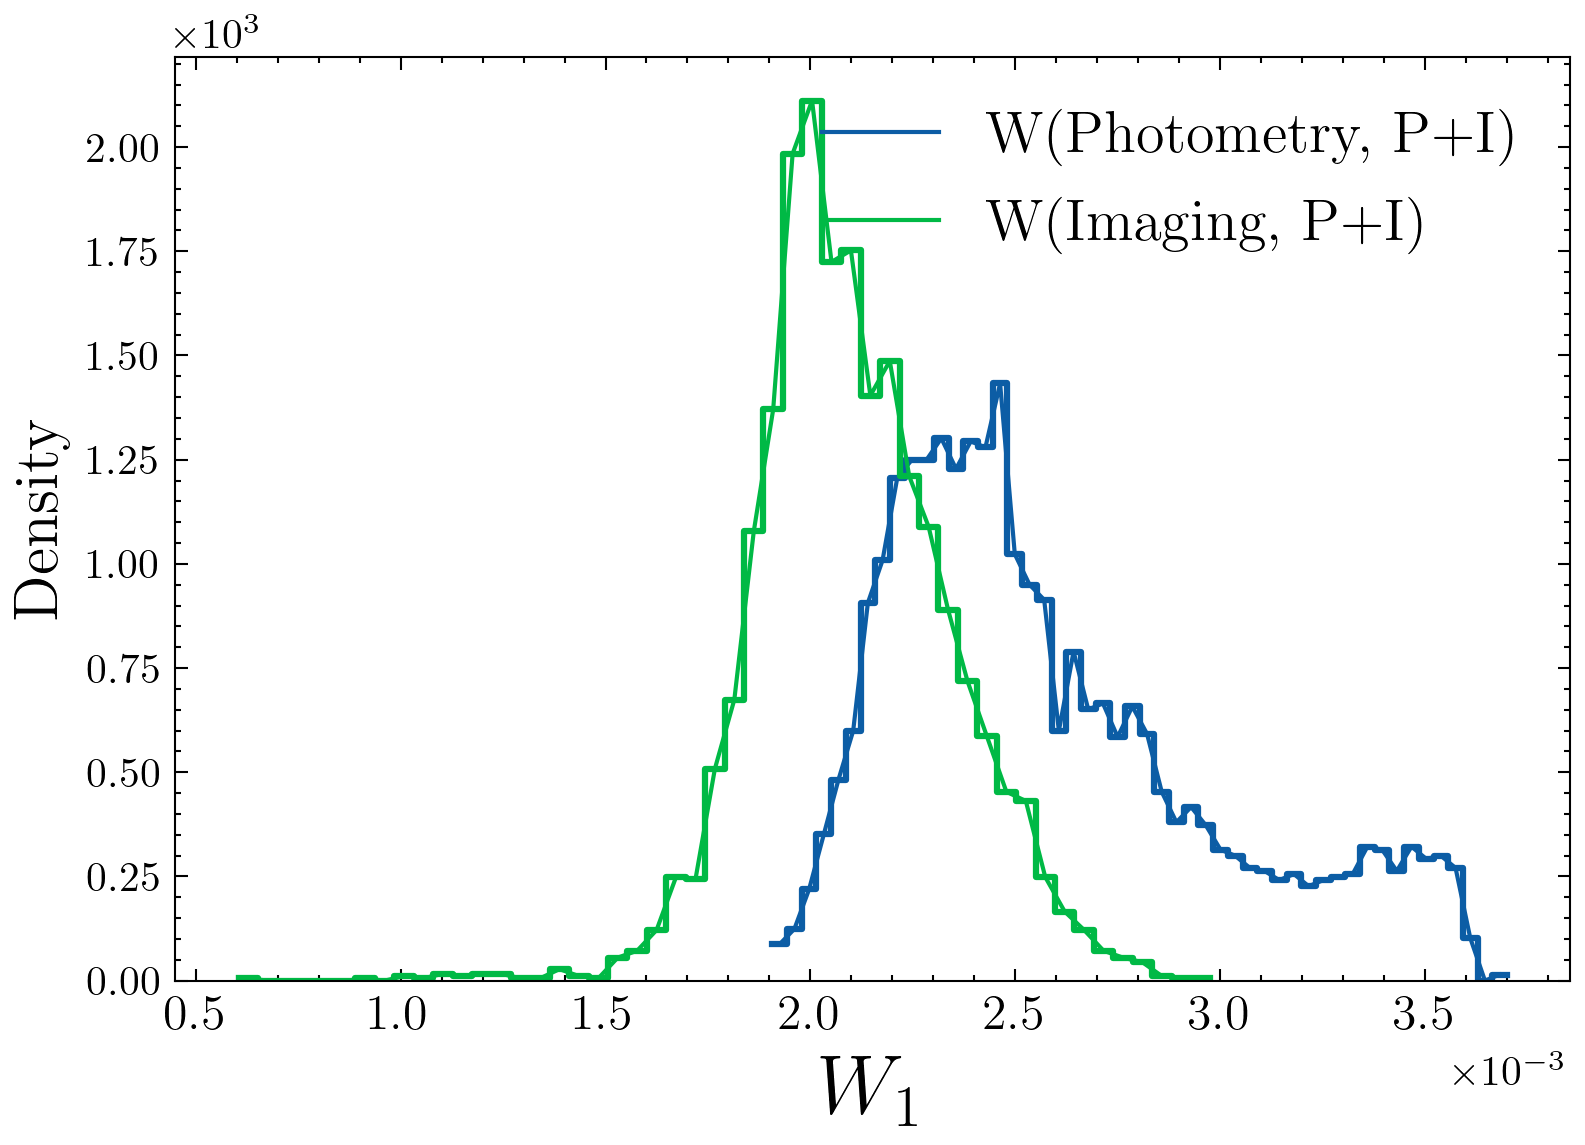

In [68]:
# plot the distributions of w1
labels = ['Photometry', 'Imaging']
df_pi = pd.DataFrame(
    data=w1s_pi,
)
df_pi.columns = labels

fig, ax = plt.subplots(
    figsize=(6,4),
    dpi=300
)

cols = labels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for col, color in zip(cols, colors):
    df_pi[col] = df_pi[col] + df[col]
    sns.histplot(df_pi[col], bins=50, lw=1.5, ax=ax, stat="density", element="step", fill=False, color=color)

    hist, edges = np.histogram(df_pi[col], bins=50, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])
    ax.plot(centers, hist, label=f"W({col}, P+I)", color=color)


plt.ylabel(r"Density", fontsize=15)
plt.xlabel(
    r"$W_{1}$",
    fontsize=20
)
plt.xticks(
    fontsize=12
)

plt.ticklabel_format(axis='both', style='sci', scilimits=(4,-4))


ax.legend(fontsize=14)

In [75]:
df.keys()

Index(['Z', 'Photometry', 'Imaging', 'Spectroscopy', 'Image + Photometry',
       'Image + Spectrum', 'Image + Spectrum + Photometry',
       'Image + Spectrum + Photometry + Z'],
      dtype='object')

In [93]:
from matplotlib.ticker import MaxNLocator


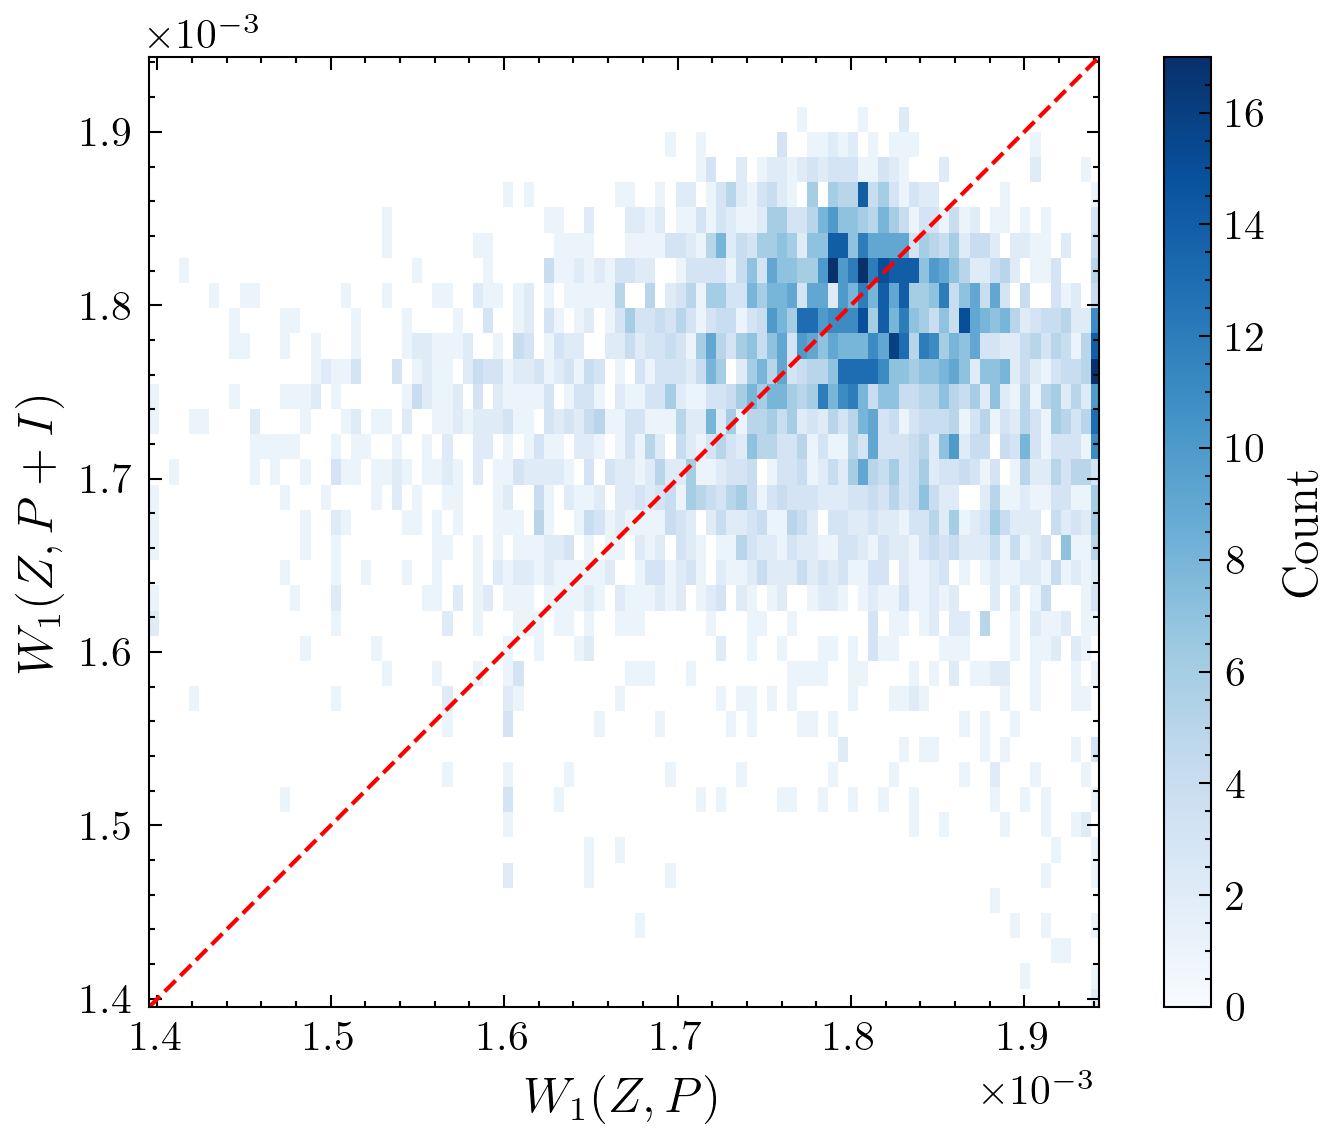

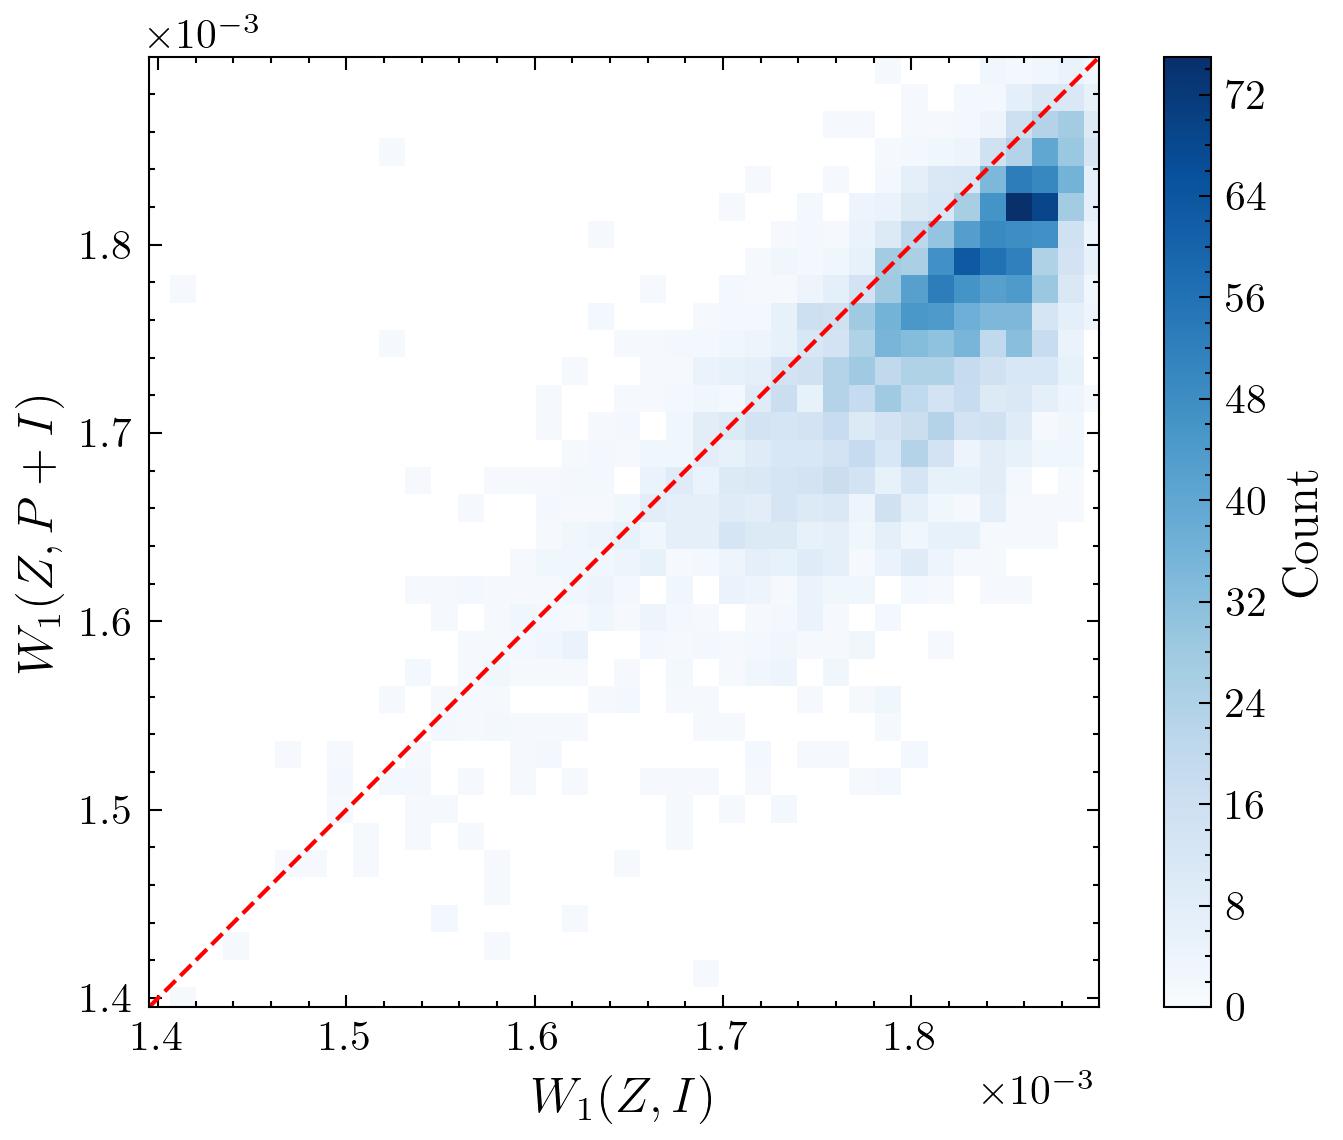

In [97]:
labels = ['Photometry', 'Imaging']
cols = labels
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for col, color in zip(cols, colors):
    # 2D histogram of original vs shifted
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

    sns.histplot(
        x=df[col],
        y=df["Image + Photometry"],
        bins=100,
        ax=ax,
        cbar=True,       # colorbar for counts
        stat="count",  # or "count"
        linewidth=0,
        pmax=0.99,
        cmap="Blues"
    )
    cbar = ax.collections[0].colorbar      # grab the colorbar created by histplot
    cbar.set_label("Count", fontsize=12)   # label
    cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # integer ticks

    # Choose limits from data (use quantiles to ignore extreme outliers)
    x_lo, x_hi = np.quantile(df[col], [0.01, 0.99])
    y_lo, y_hi = np.quantile(df["Image + Photometry"], [0.01, 0.99])

    low  = min(x_lo, y_lo)
    high = max(x_hi, y_hi)

    ax.set_xlim(low, high)
    ax.set_ylim(low, high)

    # Diagonal y = x over that range
    ax.plot([low, high], [low, high], linestyle='--', linewidth=1, c="red")

    plt.ticklabel_format(axis='both', style='sci', scilimits=(-3,-3))

    ax.set_xlabel(fr"$W_1(Z, {col[0]})$", fontsize=12)
    ax.set_ylabel(fr"$W_1(Z, P+I)$ ", fontsize=12)
    ax.set_aspect('equal')
    plt.tight_layout()

In [146]:
for i in range(10):
    for name in list(tok_z_p.keys()):
        print(name)
        u = torch.zeros_like(
            tok_z_p[name][i, :].detach().cpu()
        )
        u[round((table[i]["Z_HP"] / 6.0)*1025.0)] = 1.0

        v = tok_z_p[name][i, :].detach().cpu() 

        print(wasserstein_distance(
            u.numpy(), v.numpy()
        ))
        print(w1_distance_batched(
            u.unsqueeze(0), #.to(torch.float64),
            tok_z_p[name][i, :].unsqueeze(0) #.to(torch.float64)
        ).item())

        print("---")

true_z
0.0014305079773478109
0.0014305068785915886
---
photometry
0.0019427857586099611
0.0019427848251678515
---
imaging
0.0017881477092242363
0.0017881461668690763
---
spectroscopy
1.6258610922606553e-05
1.625859593257787e-05
---
image_photometry
0.0017631156637644058
0.0017631141313010402
---
image_spectrum
2.1138686817273322e-05
2.113866690590324e-05
---
image_spectrum_photometry
2.4249168060640584e-05
2.4249145150863806e-05
---
image_spectrum_photometry_true_z
3.4108309940039474e-05
3.410827767600147e-05
---
true_z
0.0007630149545673115
0.0007630144097117253
---
photometry
0.0019417382647810802
0.001941737330126212
---
imaging
0.0016742414400037187
0.0016742399521272014
---
spectroscopy
6.122071563868933e-06
6.122066349612178e-06
---
image_photometry
0.00167898479270476
0.0016789832882626427
---
image_spectrum
6.931012868084375e-06
6.931006660420152e-06
---
image_spectrum_photometry
8.538063673345945e-06
8.538055986153461e-06
---
image_spectrum_photometry_true_z
9.20057333066051e-

true_z


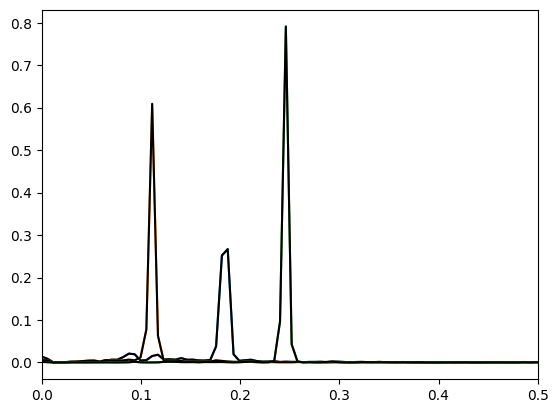

photometry


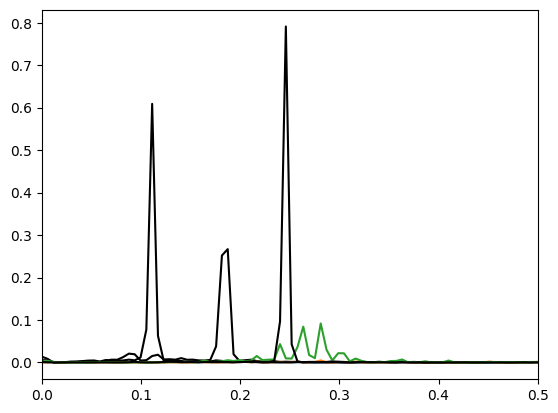

imaging


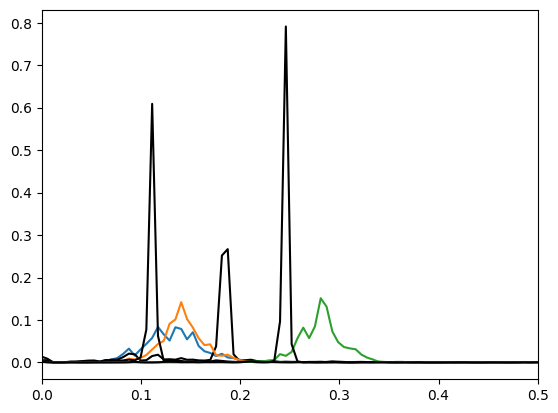

spectroscopy


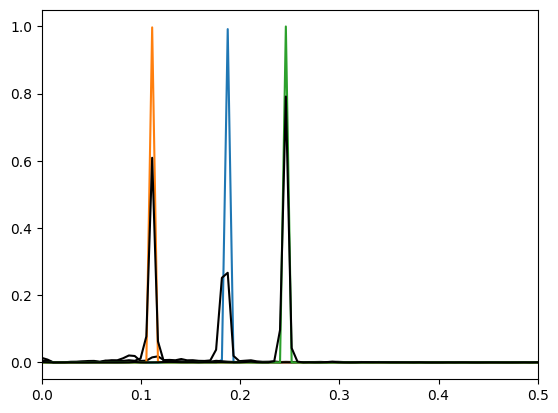

image_photometry


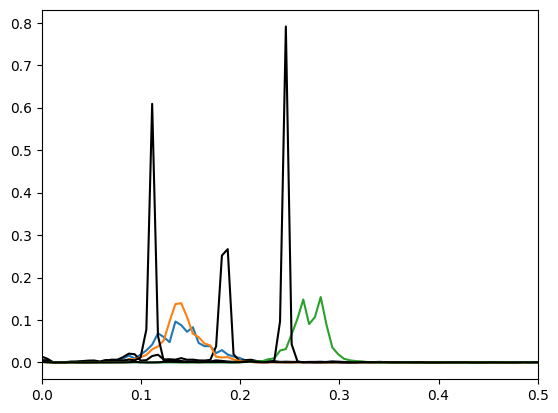

image_spectrum


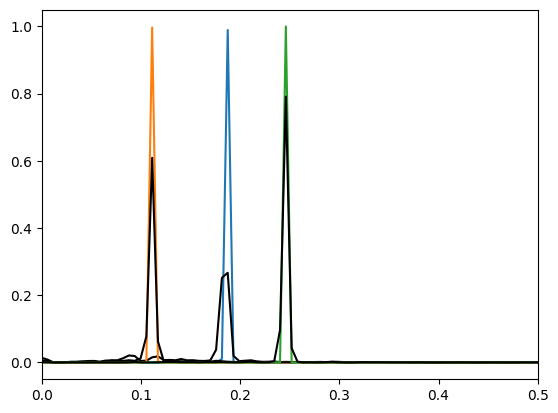

image_spectrum_photometry


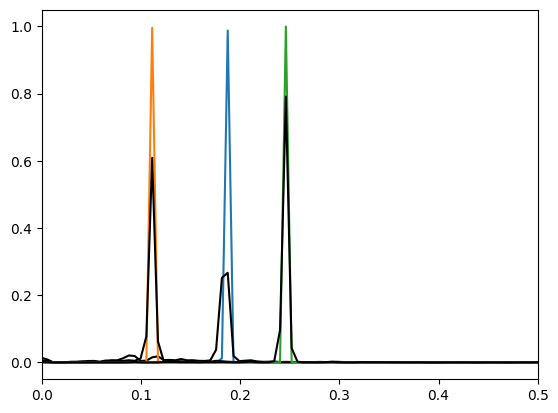

image_spectrum_photometry_true_z


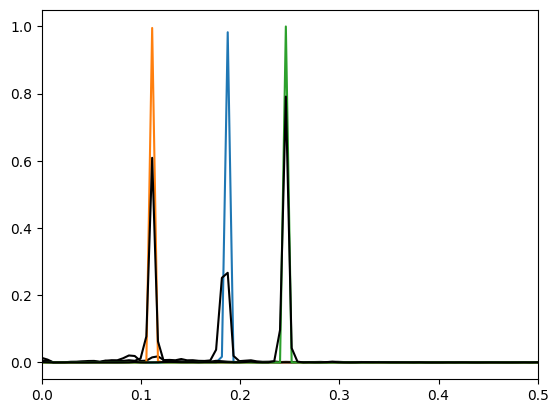

In [13]:
for name in list(tok_z_p.keys()):
    print(name)
    for i in range(3):
        z = tok_z_p[name][i, :].detach().cpu().numpy()
        plt.plot(
            np.linspace(0, 6, len(z)),
            z
        )
        plt.plot(
            np.linspace(0, 6, len(z)),
            tok_z_p["true_z"][i, :].detach().cpu().numpy(),
            c="black"
        )
        plt.xlim(0, 0.5)
        w1 = wasserstein_distance(
            
        )
        '''plt.axvline(
            table[i]["Z_HP"],
            ls="--",
            c="black"
        )'''

    plt.show()

In [49]:
import numpy as np
from scipy.stats import wasserstein_distance

# z_centers: [V] – redshift at center of each bin
# true_p, pred_p: [V] – probabilities over those bins

w1 = wasserstein_distance(
    np.linspace(0,1,len(tok_z_p["true_z"][0].detach().cpu().numpy())), 
    np.linspace(0,1,len(tok_z_p["true_z"][0].detach().cpu().numpy())),
    u_weights=tok_z_p["true_z"].detach().cpu().numpy()[0], 
    v_weights=tok_z_p["photometry"].detach().cpu().numpy()[0]
)

ValueError: Value and weight array-likes for the same empirical distribution must be of the same size.

In [46]:
w1

np.float64(9.863145842896025e-05)

In [50]:
tok_z_p["true_z"]

tensor([[1.3835e-02, 8.5729e-03, 2.9038e-04,  ..., 2.1945e-06, 2.3074e-06,
         9.1119e-04],
        [5.4796e-03, 5.1553e-03, 1.3150e-04,  ..., 4.4643e-07, 4.8500e-07,
         6.6110e-04],
        [1.4063e-03, 6.5003e-04, 4.9613e-05,  ..., 1.3190e-07, 1.5266e-07,
         8.9001e-05],
        ...,
        [4.1889e-03, 3.0068e-03, 3.8721e-04,  ..., 5.2107e-08, 5.6841e-08,
         4.3156e-04],
        [8.1587e-04, 6.5262e-04, 6.2220e-05,  ..., 1.2018e-07, 1.2201e-07,
         1.0651e-04],
        [1.3835e-02, 8.5729e-03, 2.9038e-04,  ..., 2.1945e-06, 2.3074e-06,
         9.1119e-04]])